# Twitter - kaggle -  ULMFit

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from utils import *
from sklearn.model_selection import KFold

In [2]:
torch.cuda.is_available()

True

In [3]:
from pathlib import PosixPath
path = PosixPath('/home/shanmugam/fastai/')
# path = PosixPath('/home/shanmugam/.fastai/models/wt103-fwd')
lm_fns = ['learn_en_wiki_15000', 'learn_en_wiki_15_vocab']
path


PosixPath('/home/shanmugam/fastai')

In [4]:
train_df = pd.read_csv(path/'train.csv')
train_df.loc[pd.isna(train_df.text),'text']='NA'
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df = pd.read_csv(path/'test.csv')
test_df.loc[pd.isna(test_df.text),'text']='NA'
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df = pd.concat([train_df,test_df], sort=False)

In [8]:
bs=128
data_lm = (TextList.from_df(df, path, cols='text')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

In [9]:
#learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.0)
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0).to_fp16()

In [43]:
lr = 1e-3
lr *= bs/48

In [44]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.617343,4.456182,0.276535,00:13
1,5.259024,4.177719,0.350028,00:15


In [45]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.219466,3.943643,0.375837,00:18
1,4.038679,3.757119,0.391574,00:18
2,3.871957,3.523306,0.420312,00:18
3,3.672551,3.397920,0.436384,00:18
4,3.493966,3.352379,0.442690,00:18
5,3.340390,3.296790,0.451479,00:18
6,3.229937,3.290707,0.453599,00:18
7,3.149267,3.282875,0.454018,00:18


In [12]:
lang='en'
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

### Classifier

In [14]:
data_clas = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols='text')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='target')
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class')

In [15]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

In [15]:
from sklearn.metrics import f1_score

In [16]:
@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [18]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

In [19]:
lr=2e-2
lr *= bs/48

In [20]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.601740,0.544232,0.727989,0.568383,00:01
1,0.569430,0.537054,0.747700,0.609953,00:01


In [21]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.576629,0.687154,0.688568,0.467060,00:01
1,0.555430,0.532727,0.741130,0.620634,00:01


In [22]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.548595,0.527342,0.741130,0.585640,00:02
1,0.520642,0.501762,0.760841,0.666952,00:01


In [23]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.499345,0.519685,0.766097,0.653200,00:02
1,0.467862,0.492407,0.781866,0.686761,00:02


In [24]:
learn_c.unfreeze()
learn_c.fit_one_cycle(3, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.415215,0.504529,0.785808,0.675545,00:03
1,0.401466,0.514453,0.764783,0.706156,00:03
2,0.359672,0.513721,0.781866,0.700747,00:03


In [25]:
learn_c.save(f'{lang}clas')

In [36]:
learn_lm.predict("John went to a football match", n_words=50)

"John went to a football match y - car b on y - ar c ford , 4 80 - language understanding - csx un y d pc s t . bluff ca s it ja s prepare agrees man h . or g s ii manage g en let hunger s don't s disappearance on"

## Backward

In [27]:
bs=128
data_lm = (TextList.from_df(df, path, cols='text')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))
#learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.0)
learn_lm = language_model_learner(data_lm, AWD_LSTM, config={**awd_lstm_lm_config, 'n_hid': 1152},
                                  pretrained_fnames=lm_fns, drop_mult=1.0)


lr = 1e-3
lr *= bs/48

learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))



epoch,train_loss,valid_loss,accuracy,time
0,6.627207,4.457491,0.277986,00:07
1,5.264265,4.181861,0.343778,00:06


In [28]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.217378,3.916133,0.384794,00:10
1,4.050858,3.732418,0.401507,00:10
2,3.856618,3.541379,0.436217,00:10
3,3.655553,3.400859,0.452651,00:10
4,3.476488,3.334724,0.463421,00:10
5,3.323720,3.305023,0.466713,00:10
6,3.215980,3.288818,0.469643,00:10
7,3.133718,3.281110,0.469671,00:10


In [29]:
lang='en'
learn_lm.save(f'{lang}fine_tuned_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_bwd')
data_clas = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols='text')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='target')
    .databunch(bs=bs, num_workers=1, backwards=True))

data_clas.save(f'{lang}_textlist_class_bwd')

data_clas = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_bwd')
learn_c.freeze()

In [30]:
lr=2e-2
lr *= bs/48
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.606870,0.598413,0.695138,0.429398,00:01
1,0.571485,0.528714,0.747700,0.585651,00:01


In [31]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.559272,0.556698,0.706964,0.476851,00:02
1,0.522216,0.484263,0.785808,0.677238,00:01


In [32]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.503359,0.494776,0.772668,0.686364,00:02
1,0.476957,0.470973,0.789750,0.711484,00:02


In [35]:
learn_c.unfreeze()
learn_c.fit_one_cycle(3, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.314185,0.576438,0.773982,0.686679,00:03
1,0.300418,0.584375,0.771353,0.698708,00:03
2,0.264766,0.622777,0.770039,0.688253,00:03


In [36]:
learn_c.save(f'{lang}clas_bwd')

## Ensemble

In [60]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)
data_clas.add_test(test_df)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load(f'{lang}clas', purge=False);

In [63]:
preds,targs = learn_c.get_preds(DatasetType.Test)
accuracy(preds,targs),f1(preds,targs)

/home/shanmugam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


(tensor(0.5584), tensor(0.))

In [62]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)
data_clas_bwd.add_test(test_df)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_bwd', purge=False);

In [64]:
preds_b,targs_b = learn_c_bwd.get_preds(DatasetType.Test)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

/home/shanmugam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


(tensor(0.5133), tensor(0.))

In [107]:
DatasetType.Test

<DatasetType.Test: 3>

In [65]:
preds_avg = (preds+preds_b)/2

In [53]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

NameError: name 'preds_avg' is not defined

In [69]:
sub = pd.read_csv(path/'sample_submission.csv')

In [72]:
sub.target = preds_avg.argmax(dim=-1)
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [71]:
sub['target'].value_counts()

0    1769
1    1494
Name: target, dtype: int64

In [73]:
sub.to_csv('model_lin.csv', index=False)

## MixedTabular ItemList

In [42]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [66]:

cat_cols = [
    'keyword', 
    'location', 
]

# cont_cols = [
#     'c', 
#     'funny',
#     'useful',
#     'user_average_stars',
#     'business_stars'
# ]
cont_cols = None
txt_cols = ['text']

dep_var = ['target']

In [53]:
procs = [FillMissing, Categorify]

In [136]:
data_cls_mx = (MixedTabularList.from_df(train_df, cat_cols, cont_cols, txt_cols,
                                     vocab=data_lm.vocab, procs=procs, path=path)
          .split_by_rand_pct(valid_pct=0.1, seed=42)
          .label_from_df(dep_var)
          .databunch(bs=128))

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7606  10866     NaN      NaN   
7607  10867     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7606  Suicide bomber kills 15 in Saudi security site...       1  
7607  #stormchase Violent Record Breaking EF-5 El Re...       1  
7609  @aria_ahrary @T

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7606  10866     NaN      NaN   
7607  10867     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7606  Suicide bomber kills 15 in Saudi security site...       1  
7607  #stormchase Violent Record Breaking EF-5 El Re...       1  
7609  @aria_ahrary @T

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7606  10866     NaN      NaN   
7607  10867     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7606  Suicide bomber kills 15 in Saudi security site...       1  
7607  #stormchase Violent Record Breaking EF-5 El Re...       1  
7609  @aria_ahrary @T

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7606  10866     NaN      NaN   
7607  10867     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7606  Suicide bomber kills 15 in Saudi security site...       1  
7607  #stormchase Violent Record Breaking EF-5 El Re...       1  
7609  @aria_ahrary @T

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7606  10866     NaN      NaN   
7607  10867     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7606  Suicide bomber kills 15 in Saudi security site...       1  
7607  #stormchase Violent Record Breaking EF-5 El Re...       1  
7609  @aria_ahrary @T

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7606  10866     NaN      NaN   
7607  10867     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7606  Suicide bomber kills 15 in Saudi security site...       1  
7607  #stormchase Violent Record Breaking EF-5 El Re...       1  
7609  @aria_ahrary @T

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7606  10866     NaN      NaN   
7607  10867     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7606  Suicide bomber kills 15 in Saudi security site...       1  
7607  #stormchase Violent Record Breaking EF-5 El Re...       1  
7609  @aria_ahrary @T

In [137]:
data_cls_mx.add_test(test_df)

TypeError: 'NoneType' object is not subscriptable

In [69]:

print(f'CATS:\n{data_cls_mx.train_ds.cat_names}')
print(f'CONTS:\n{data_cls_mx.train_ds.cont_names}')
print(f'TEXT COLS:\n{data_cls_mx.train_ds.text_cols}')
print(f'PROCS:\n{data_cls_mx.train_ds.procs}')

CATS:
['keyword', 'location']
CONTS:
[]
TEXT COLS:
['text']
PROCS:
[<class 'fastai.tabular.transform.FillMissing'>, <class 'fastai.tabular.transform.Categorify'>]


In [71]:
len(data_cls_mx.train_ds.x.vocab.itos), len(data_cls_mx.valid_ds.x.vocab.itos)

(5464, 5464)

In [72]:

data_cls_mx.show_batch()

keyword,location,target
body%20bags,"southwest, Tx",0
cyclone,#na#,1
drown,#na#,0
blizzard,"Houston, TX",0
screaming,9/1/13,0


text_data,target
xxbos(2) xxmaj(5) shoot(3134) shit(241) up(51) till(1094) we(57) see(145) body(116) bags(403),0
xxbos(2) xxunk(0) xxmaj(5) we(57) need(181) these(295) plants(3801) in(18) the(14) pacific(2818) during(267) the(14) cyclone(626) seasons(3560) it(32) would(98) help(223),1
xxbos(2) i(20) am(215) that(35) girl(346) on(29) tv(770) that(35) sadly(2178) turns(3695) her(103) music(697) up(51) to(17) drown(496) out(63) the(14) noise(3979) of(19) her(103) family(291) fighting(1364) literally(814) every(280) day(135),0
xxbos(2) @blizzard_draco(3678) @lonewolffur(3107) i(20) need(181) this(40) .(15),0
xxbos(2) xxup(6) screaming(377) xxup(6) in(18) 22(1862) xxup(6) different(1402) xxup(6) languages(5314) http(12) :(10) /(9) /(9) t.co(11) /(9) xxunk(0),0


In [73]:

from fastai.callbacks import hook_output
from fastai.text.learner import RNNTrainer, masked_concat_pool

tab_layers = [200, 100]
tabular_args = {
    'metrics': accuracy, 
    'ps': [.05, .03], 
    'emb_drop': 0.3, 
    #'y_range': [1, 5.1]
}

bptt = 70
emb_size = 400
n_hidden = 1150
n_layers = 3

max_seq = 70*20
drop_mult = 0.5

text_args = {
    'bptt': bptt, 
    'drop_mult': drop_mult,
    'max_len': max_seq
}

In [78]:
class TabularTextNN(nn.Module):
    def __init__(self, data, tab_layers, tab_args={}, text_args={}):
        super().__init__()
        
        tab_learner = tabular_learner(data, tab_layers, **tab_args)
        tab_learner.model.layers = tab_learner.model.layers[:-1]
        self.tabular_model = tab_learner.model

        text_class_learner = text_classifier_learner(data, AWD_LSTM, **text_args)
        text_class_learner.load_encoder(f'{lang}fine_tuned_enc')
        self.text_enc_model = list(text_class_learner.model.children())[0]
        
        self.bn_concat = nn.BatchNorm1d(400*3+100)
        
        self.lin = nn.Linear(400*3+100, 50)
        self.final_lin = nn.Linear(50, data.c)
        
    def forward(self, x_cat:Tensor, x_cont:Tensor, text_input:Tuple[Tensor,Tensor]) -> Tensor:
        # grab the tabular results minus the last layer
        tab_res = self.tabular_model.forward(x_cat, x_cont)

        # grab the results of the encoder
        raw_outputs, outputs, mask = self.text_enc_model(text_input)
        text_final_rnn_output = masked_concat_pool(outputs, mask) #outputs[-1][:,-1] # => (bs, 400*3)
  
        # do the concat pooling trick with the tabular and text encoder results
        x = torch.cat([tab_res, text_final_rnn_output], dim=1)
        x = self.bn_concat(x)
        
        # run the final results though a couple of linears
        x = self.final_lin(F.relu(self.lin(x)))
        
        # return the goods
        return x, raw_outputs, outputs
    
    def reset(self):
        self.text_enc_model.reset()

In [88]:

model = TabularTextNN(data_cls_mx, tab_layers, tabular_args, text_args)

In [89]:

learn = None; gc.collect()
learn = Learner(data_cls_mx, model, metrics=[accuracy])

In [90]:
learn.callbacks.append(RNNTrainer(learn, bptt))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


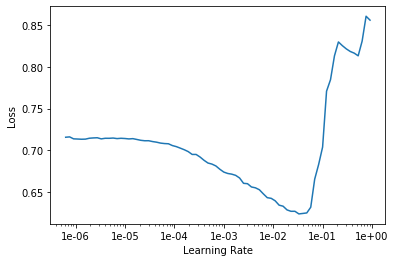

In [91]:
learn.lr_find()
learn.recorder.plot()


In [92]:
learn.fit_one_cycle(1, 1e-2, wd=1e-2, pct_start=0.2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.532751,0.502335,0.771353,00:20


In [93]:
# learn.unfreeze()
learn.fit_one_cycle(5, 1e-2, wd=1e-2, pct_start=0.2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.414772,0.517532,0.752957,00:20
1,0.383876,0.540472,0.752957,00:20
2,0.345123,0.569790,0.752957,00:20
3,0.303561,0.589536,0.751643,00:20
4,0.279713,0.597605,0.750329,00:20


## Mixed tab+text learner

In [73]:
def get_val_idxs(train,n_splits=20):
    np.random.seed(42)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idxs, valid_idxs = next(cv.split(train))
    return train_idxs,valid_idxs

cat_cols = [
    'keyword', 
    'location', 
]

# cont_cols = [
#     'c', 
#     'funny',
#     'useful',
#     'user_average_stars',
#     'business_stars'
# ]
cont_cols = None
txt_cols = ['text']

dep_var = ['target']

procs = [FillMissing, Categorify]

train_idxs,val_idxs = get_val_idxs(train_df,n_splits=20)
# train_idxs,val_idxs = get_val_idxs(train_df,n_splits=5)
train_idxs,val_idxs
train_idxs.shape,val_idxs.shape

((7232,), (381,))

In [74]:
text_db = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols='text')
    .split_by_idx(val_idxs)
    .label_from_df(cols='target')
    .add_test(test_df)
    .databunch(bs=bs, num_workers=1))

tab_db = (TabularList.from_df(train_df, cat_cols, cont_cols, procs=procs, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols='target')
                            .add_test(TabularList.from_df(test_df, cat_cols, cont_cols, txt_cols,path=path))
                            .databunch(bs=bs))


In [75]:
train_ds = ConcatDataset(tab_db.train_ds.x, text_db.train_ds.x, tab_db.train_ds.y)
valid_ds = ConcatDataset(tab_db.valid_ds.x, text_db.valid_ds.x, tab_db.valid_ds.y)
    
train_sampler = SortishSampler(text_db.train_ds.x, key=lambda t: len(text_db.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda t: len(text_db.valid_ds[t][0].data))

#     train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=tabtext_collate, path=path)

In [92]:
doc(SortishSampler)

In [57]:
tab_params={
    'layers':[500],
    'emb_drop': 0.3,
    'y_range': [0,6],
    'use_bn': True,
    'ps': [0.4]
    }

text_params={
    #     'lin_ftrs':[1000],
         'ps': [0.6],
        'bptt':70,
        'max_len':20*70,
        'drop_mult': 0.5, 
    #     'use_bn': True,    
    }

In [59]:
# tab_learner = tabular_learner(data,metrics=[root_mean_squared_error],**params)
tab_learner = tabular_learner(tab_db,metrics=[accuracy,f1],**tab_params)
text_learner = text_classifier_learner(text_db,AWD_LSTM,metrics=[accuracy,f1],**text_params)
text_learner = text_learner.load_encoder('enfine_tuned_enc')

In [60]:
from tabtext import *
lin_layers=[500]
#ps=[0.7]

# 50 is the default lin_ftrs in AWD_LSTM
lin_layers[-1]+= 50 if 'lin_ftrs' not in text_params else text_params['lin_ftrs']

# be careful here. If no lin_ftrs is specified, the default lin_ftrs is 50

learner = get_tabtext_learner(data,tab_learner,text_learner,lin_layers ,ps)

In [61]:
learner.freeze()
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,f1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


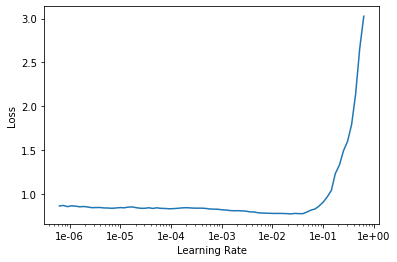

In [62]:
learner.recorder.plot(skip_end=1)

In [64]:
learner.freeze()
lr=2e-2
lr *= bs/48

In [65]:
learner.fit_one_cycle(5, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.363866,0.885138,0.650919,0.675659,00:13
1,0.849006,0.598660,0.711286,0.685086,00:18
2,0.555391,0.595673,0.729659,0.686973,00:18
3,0.400768,0.613634,0.737533,0.664342,00:18
4,0.329999,0.614737,0.748031,0.697874,00:18


In [67]:
# learner.freeze_to(-2)
learner.unfreeze()

learner.fit_one_cycle(5, slice(1e-03/(2.6**4),1e-03), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.284677,0.654426,0.755906,0.716397,00:40
1,0.276785,0.673929,0.745407,0.716170,00:43
2,0.279143,0.664988,0.740157,0.689871,00:43
3,0.259026,0.663742,0.729659,0.684345,00:43
4,0.248328,0.677782,0.729659,0.670386,00:43


In [93]:
text_learner.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(5464, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(5464, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
    )
  )
)